## Time Series Modeling -  Hourly Water Consumption Forecasting in the Greater Stuttgart
Landeswasserversorgung

In [62]:
# Import Packages
import numpy as np
import pandas as pd

import math

# statistics

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error

import pmdarima as pmd  # for auto_arima

# missing data

from statsmodels.imputation.mice import MICEData  # for MICE imputation

import missingno as msno  # for missing data visualization

# plotting

import matplotlib.pyplot as plt

import matplotlib.dates as mdates

import seaborn as sns  # for correlation matrix

# read data

import h5py  # for hdf5 files

import json

import holidays

import gzip  # for gzip files

import shutil  # for gzip files

import warnings


# own functions

from utils.sarima_forecast import (

    train_and_forecast_sarima,

)  # for SARIMA model training and forecasting

from utils.fourier import fourier_series


# Prophet

from prophet import Prophet

from prophet.utilities import regressor_coefficients  # regression coefficients

from prophet.diagnostics import cross_validation

from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric


warnings.filterwarnings("ignore")

### 1.) Load Data

#### 1.1.) Read in water demand data
Water demand from the Landeswasserversorgung at hourly level in l/s

In [2]:
# Explore the structure of an HDF5 file
def explore_h5_structure(h5_file):
    for key in h5_file.keys():
        print(f"Group/Dataset: {key}")
        if isinstance(h5_file[key], h5py.Group):
            explore_h5_structure(h5_file[key])  # Recursively explore groups
        elif isinstance(h5_file[key], h5py.Dataset):
            print(f"Dataset shape: {h5_file[key].shape}, dtype: {h5_file[key].dtype}")

In [3]:
# Open the file
with h5py.File("../data/water_demand/system_demand.h5", "r") as system_demand:
    explore_h5_structure(system_demand)

Group/Dataset: system_demand
Group/Dataset: n_nodal_datapoints_available
Dataset shape: (247463,), dtype: float64
Group/Dataset: nodal_demand_sum
Dataset shape: (247463,), dtype: float64
Group/Dataset: time
Dataset shape: (7, 247463), dtype: int64


In [4]:
with h5py.File("../data/water_demand/system_demand.h5", "r") as system_demand:
    # Access a specific group
    group = system_demand["system_demand"]
    # Load the dataset into memory
    n_nodal_datapoints_available = group["n_nodal_datapoints_available"][:]
    nodal_demand = group["nodal_demand_sum"][:]
    system_time = group["time"][:]

In [5]:
# Build pandas df with datetime, nodal_demand_sum, n_nodal_datapoints_available
system_time_transposed = np.transpose(
    system_time
)  # transpose system time in long format
# create dataframe
df = pd.DataFrame(
    system_time_transposed,
    columns=["year", "month", "day", "hour", "minute", "second", "milisecond"],
)
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour", "minute"]])
df["nodal_demand"] = nodal_demand
df["n_nodal_datapoints_available"] = n_nodal_datapoints_available
df.set_index("datetime", inplace=True)
df_hourly = df.resample(
    "h"
).median()  # Use sum for total demand per hour.resample('h').mean() #resample to hourly mean demand in liter/s
df_hourly = df_hourly.drop(
    columns=["year", "month", "day", "hour", "minute", "second", "milisecond"]
)
df_hourly["date"] = df_hourly.index
df_hourly.head(5)

,nodal_demand,n_nodal_datapoints_available,date
datetime,,,
2016-12-30 23:00:00,3117.642772,29.0,2016-12-30 23:00:00
2016-12-31 00:00:00,2476.503474,29.0,2016-12-31 00:00:00
2016-12-31 01:00:00,2336.120475,29.0,2016-12-31 01:00:00
2016-12-31 02:00:00,1882.216795,29.0,2016-12-31 02:00:00
2016-12-31 03:00:00,1821.650324,29.0,2016-12-31 03:00:00


##### 1.1.1.) Deal with missing data


In [6]:
# Only seven missing values, impute via mean of nearest neighbors
df_hourly[df_hourly["nodal_demand"].isna()]

,nodal_demand,n_nodal_datapoints_available,date
datetime,,,
2017-03-26 02:00:00,NaN,NaN,2017-03-26 02:00:00
2018-03-25 02:00:00,NaN,NaN,2018-03-25 02:00:00
2019-03-31 02:00:00,NaN,NaN,2019-03-31 02:00:00
2020-03-29 02:00:00,NaN,NaN,2020-03-29 02:00:00
2021-03-28 02:00:00,NaN,NaN,2021-03-28 02:00:00
2022-03-27 02:00:00,NaN,NaN,2022-03-27 02:00:00
2023-03-26 02:00:00,NaN,NaN,2023-03-26 02:00:00


In [7]:
# Fill missing values with the previous value
df_hourly = df_hourly.fillna(method="ffill")

#### 1.2.) Read in weather and holiday data
Weather data from the DWD stations Stuttgart-Schnarrenberg and Stuttgart-Echterdingen

In [8]:
# Load the Raw temperature data
temperature_schnarrenberg = pd.read_csv(
    "../data/weather_climate/Temperaturdaten_Schnarrenberg_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"TT_TU": "temperature"})

temperature_echterdingen = pd.read_csv(
    "../data/weather_climate/Temperaturdaten_Echterdingen_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"TT_TU": "temperature"})

temperature = pd.merge(
    temperature_schnarrenberg,
    temperature_echterdingen,
    left_index=True,
    right_index=True,
    suffixes=("_Schnar", "_Echt"),
)

In [9]:
sun_schnarrenberg = pd.read_csv(
    "../data/weather_climate/Sonnenschein_Schnarrenberg_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"SD_SO": "sunshine_duration"})

sun_echterdingen = pd.read_csv(
    "../data/weather_climate/Sonnenschein_Echterdingen_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"SD_SO": "sunshine_duration"})

sunshine = pd.merge(
    sun_schnarrenberg,
    sun_echterdingen,
    left_index=True,
    right_index=True,
    suffixes=("_Schnar", "_Echt"),
)

In [10]:
precipitation_schnarrenberg = pd.read_csv(
    "../data/weather_climate/Niederschlag_Schnarrenberg_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"  R1": "precipitation"})

precipitation_echterdingen = pd.read_csv(
    "../data/weather_climate/Niederschlag_Echterdingen_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"  R1": "precipitation"})


precipitation = pd.merge(
    precipitation_schnarrenberg,
    precipitation_echterdingen,
    left_index=True,
    right_index=True,
    suffixes=("_Schnar", "_Echt"),
)

In [11]:
soil = pd.read_csv(
    "../data/weather_climate/derived_germany_soil_daily_historical_4928.csv",
    delimiter=";",
    parse_dates=["Datum"],
).rename(columns={"Datum": "date"})
soil = soil[["date", "BF10", "BF20", "BF30", "BF40", "BF50", "BF60"]]

In [12]:
# create weather data
weather = pd.merge(
    temperature, sunshine, left_index=True, right_index=True, how="outer"
).merge(
    precipitation, left_index=True, right_index=True, how="outer"
)  # Merge all hourly weather data

weather.index = pd.to_datetime(weather.index, format="%Y%m%d%H")
weather["datetime"] = pd.to_datetime(weather.index)
weather["date"] = pd.to_datetime(weather.index.date)
weather = pd.merge(weather, soil, on="date", how="left")  # merge soil data
weather = weather.set_index("datetime")  # reset index
weather.replace(-999, np.nan, inplace=True)  # Replace missing values with NaN
weather = weather[
    [
        "temperature_Schnar",
        "temperature_Echt",
        "sunshine_duration_Schnar",
        "sunshine_duration_Echt",
        "precipitation_Schnar",
        "precipitation_Echt",
        "BF10",
        "BF20",
        "BF30",
        "BF40",
        "BF50",
        "BF60",
    ]
]
weather = weather[weather.index >= "2018-01-01"]  # select data from 2018 onwards

##### 1.2.1.) Deal with missing data
Probably due to maintaince issues a "Missing at Random" (MAR) mechansim is given for the weather data, for both weather stations. Multiple Imputation (MI) is considered to impute missing data.

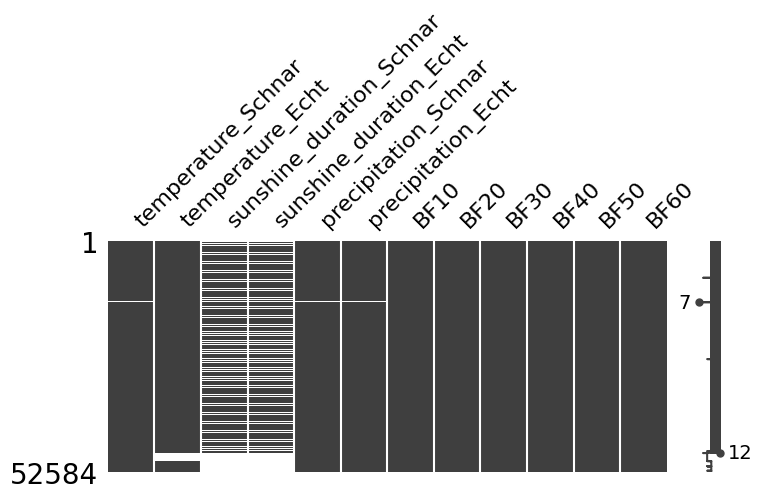

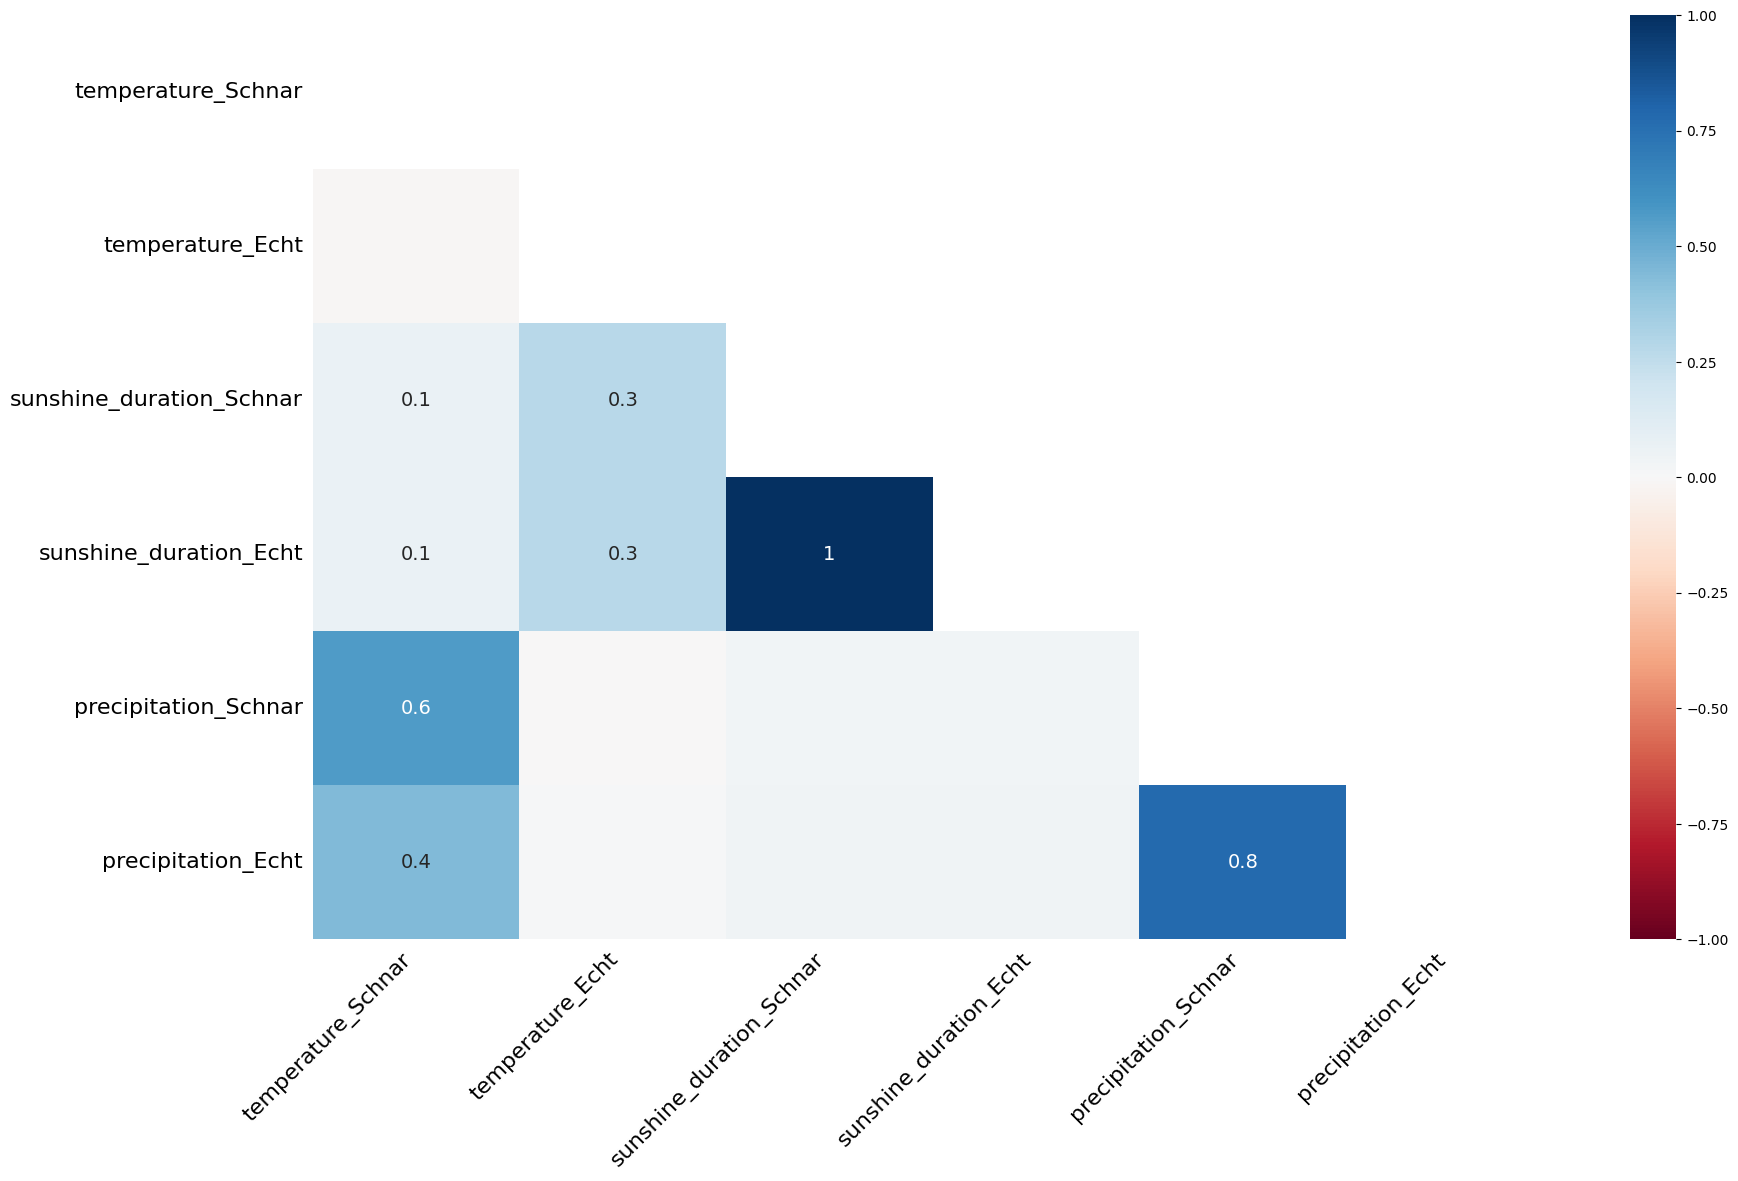

In [13]:
# Optional: Visualize missingness
msno.matrix(weather, figsize=(8, 3))
msno.heatmap(weather)
plt.show()

In [14]:
## Conduct multiple imputation using MICE

# Store original index
original_index = weather.index.copy()

# Initialize MICEData object
mice_data = MICEData(weather)

# Impute missing values
mice_data.update_all()

# Check imputed dataset
weather_imputed = mice_data.data.copy()
weather_imputed.index = original_index  # Reassign the original index
weather_imputed.head()

,temperature_Schnar,temperature_Echt,sunshine_duration_Schnar,sunshine_duration_Echt,precipitation_Schnar,precipitation_Echt,BF10,BF20,BF30,BF40,BF50,BF60
datetime,,,,,,,,,,,,
2018-01-01 00:00:00,8.9,9.2,0.0,0.0,0.1,0.0,95.0,98.0,101.0,101.0,99.0,96.0
2018-01-01 01:00:00,9.0,8.4,0.0,0.0,0.3,0.0,95.0,98.0,101.0,101.0,99.0,96.0
2018-01-01 02:00:00,8.8,7.9,15.0,13.0,0.0,0.0,95.0,98.0,101.0,101.0,99.0,96.0
2018-01-01 03:00:00,8.2,7.7,0.0,0.0,0.0,0.0,95.0,98.0,101.0,101.0,99.0,96.0
2018-01-01 04:00:00,8.2,7.3,0.0,0.0,0.0,0.0,95.0,98.0,101.0,101.0,99.0,96.0


#### 1.3.) Add holiday data
Add holiday data for the state of Baden-Württemberg 

In [15]:
bw_holidays = holidays.country_holidays(
    years=np.arange(2018, 2024), country="DE", subdiv="BW"
)
bw_holidays.keys()

dict_keys([datetime.date(2018, 1, 1), datetime.date(2018, 3, 30), datetime.date(2018, 4, 2), datetime.date(2018, 5, 1), datetime.date(2018, 5, 10), datetime.date(2018, 5, 21), datetime.date(2018, 10, 3), datetime.date(2018, 12, 25), datetime.date(2018, 12, 26), datetime.date(2018, 1, 6), datetime.date(2018, 5, 31), datetime.date(2018, 11, 1), datetime.date(2019, 1, 1), datetime.date(2019, 4, 19), datetime.date(2019, 4, 22), datetime.date(2019, 5, 1), datetime.date(2019, 5, 30), datetime.date(2019, 6, 10), datetime.date(2019, 10, 3), datetime.date(2019, 12, 25), datetime.date(2019, 12, 26), datetime.date(2019, 1, 6), datetime.date(2019, 6, 20), datetime.date(2019, 11, 1), datetime.date(2020, 1, 1), datetime.date(2020, 4, 10), datetime.date(2020, 4, 13), datetime.date(2020, 5, 1), datetime.date(2020, 5, 21), datetime.date(2020, 6, 1), datetime.date(2020, 10, 3), datetime.date(2020, 12, 25), datetime.date(2020, 12, 26), datetime.date(2020, 1, 6), datetime.date(2020, 6, 11), datetime.date(

In [16]:
# Create holiday object for Germany, specifically for Baden-Württemberg (BW)
bw_holidays = holidays.Germany(years=np.arange(2018, 2024), subdiv="BW")

# Extract holiday dates as a list of datetime.date objects
holiday_dates = list(bw_holidays.keys())

# Read in holiday data for Bade-Württemberg - set as binary variable
df_hourly["is_holiday"] = df_hourly["date"].dt.date.isin(holiday_dates).astype(int)

In [77]:
df_merged = pd.merge(
    df_hourly,
    weather_imputed[
        [
            "temperature_Schnar",
            "sunshine_duration_Schnar",
            "precipitation_Schnar",
            "BF10",
            "BF20",
            "BF30",
            "BF40",
            "BF50",
            "BF60",
        ]
    ],
    on="datetime",
    how="inner",
)
df_merged["T_hot"] = np.maximum(df_merged["temperature_Schnar"] - 25, 0)
df_merged["T_hot^2"] = (
    df_merged["T_hot"] ** 2
)  # Create squared term for hot temperature to consider non-linear effects
# Add a column to indicate whether the day is a working day or a weekend
df_merged["day_of_week"] = df_merged.index.dayofweek
df_merged["is_weekend"] = (df_merged["day_of_week"] >= 5).astype(int)

df_merged.tail(5)

,nodal_demand,n_nodal_datapoints_available,date,is_holiday,temperature_Schnar,sunshine_duration_Schnar,precipitation_Schnar,BF10,BF20,BF30,BF40,BF50,BF60,T_hot,T_hot^2,day_of_week,is_weekend
datetime,,,,,,,,,,,,,,,,,
2023-12-31 19:00:00,3234.205803,35.0,2023-12-31 19:00:00,0,6.3,25.0,0.0,93.0,97.0,101.0,103.0,103.0,103.0,0.0,0.0,6,1
2023-12-31 20:00:00,2897.477640,35.0,2023-12-31 20:00:00,0,6.3,0.0,0.0,93.0,97.0,101.0,103.0,103.0,103.0,0.0,0.0,6,1
2023-12-31 21:00:00,2588.741674,35.0,2023-12-31 21:00:00,0,5.9,5.0,0.0,93.0,97.0,101.0,103.0,103.0,103.0,0.0,0.0,6,1
2023-12-31 22:00:00,2588.316982,35.0,2023-12-31 22:00:00,0,5.2,50.0,0.0,93.0,97.0,101.0,103.0,103.0,103.0,0.0,0.0,6,1
2023-12-31 23:00:00,2166.669274,35.0,2023-12-31 23:00:00,0,5.1,16.0,0.0,93.0,97.0,101.0,103.0,103.0,103.0,0.0,0.0,6,1


#### 1.4.) Add interaction terms

In [ ]:
# create interaction terms
df_merged["dry_soil_10"] = np.minimum(0, df_merged["BF10"] - 50) * -1
df_merged["dry_soil_30"] = np.minimum(0, df_merged["BF30"] - 50) * -1
df_merged["dry_soil_10*temperature_Schnar"] = (
    df_merged["dry_soil_10"] * df_merged["temperature_Schnar"]
)
df_merged["dry_soil_30*temperature_Schnar"] = (
    df_merged["dry_soil_30"] * df_merged["temperature_Schnar"]
)
df_merged["dry_soil_10*T_hot"] = df_merged["dry_soil_10"] * df_merged["T_hot"]
df_merged["dry_soil_30*T_hot"] = df_merged["dry_soil_30"] * df_merged["T_hot"]

In [159]:
# Add change rate in BF30 - show dataset
# Calculate the percentage change in the 'BF30' column
df_merged["BF30_change_rate"] = df_merged["BF30"].pct_change()

# If you want to fill NaN values that result from the pct_change calculation (e.g., the first row)
df_merged["BF30_change_rate"].fillna(0, inplace=True)
df_merged.head(5)

,nodal_demand,n_nodal_datapoints_available,date,is_holiday,temperature_Schnar,sunshine_duration_Schnar,precipitation_Schnar,BF10,BF20,BF30,...,T_hot^2,day_of_week,is_weekend,dry_soil_10,dry_soil_30,dry_soil_10*temperature_Schnar,dry_soil_30*temperature_Schnar,dry_soil_10*T_hot,dry_soil_30*T_hot,BF30_change_rate
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,2481.356308,30.0,2018-01-01 00:00:00,1,8.9,0.0,0.1,95.0,98.0,101.0,...,0.0,0,0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
2018-01-01 01:00:00,2414.395364,30.0,2018-01-01 01:00:00,1,9.0,0.0,0.3,95.0,98.0,101.0,...,0.0,0,0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
2018-01-01 02:00:00,2156.941040,30.0,2018-01-01 02:00:00,1,8.8,15.0,0.0,95.0,98.0,101.0,...,0.0,0,0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
2018-01-01 03:00:00,2046.451207,30.0,2018-01-01 03:00:00,1,8.2,0.0,0.0,95.0,98.0,101.0,...,0.0,0,0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0
2018-01-01 04:00:00,2098.246382,30.0,2018-01-01 04:00:00,1,8.2,0.0,0.0,95.0,98.0,101.0,...,0.0,0,0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0


### 2.) Investigate Data

#### 2.1.) Mid/Long Term

In [148]:
# Check plots for the year 2023
start_date = pd.Timestamp("2023-01-01T00")
end_date = start_date + pd.Timedelta(days=364, hours=23)
year_data = df_merged.loc[start_date:end_date]

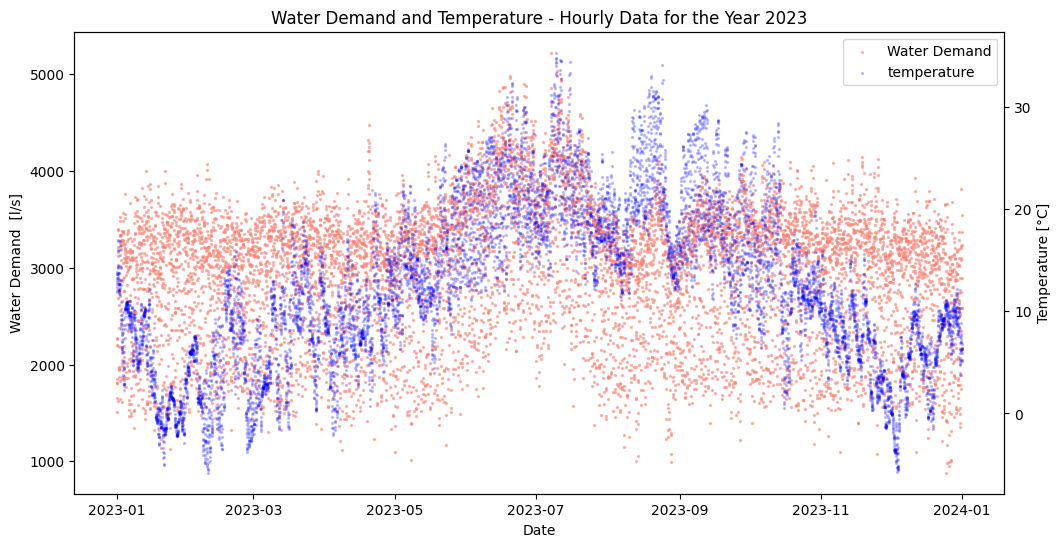

In [138]:
# Plot - Water Demand and Temperature
plt.style.use("default")

fig, ax1 = plt.subplots(figsize=(12, 6))


# Create a label for the year

label = f"{start_date.year}"


scatter1 = ax1.scatter(
    year_data.index,

    year_data["nodal_demand"],

    s=2,  # Size of dots

    alpha=0.5,  # Transparency of dots

    label="Water Demand",
    color="salmon",
)

ax1.set_xlabel("Date")

ax1.set_ylabel("Water Demand  [l/s]")


# Create a second y-axis for the temperature

ax2 = ax1.twinx()

scatter2 = ax2.scatter(
    year_data.index,

    year_data["temperature_Schnar"],

    s=2,  # Size of dots

    alpha=0.2,  # Transparency of dots

    label="Temperature",
    color="blue",
)

ax2.set_ylabel("Temperature [°C]")


# Combine legends

scatters = [scatter1, scatter2]

labels = [scatter.get_label() for scatter in scatters]

ax1.legend(scatters, labels, loc="upper right")

plt.title(f"Water Demand and Temperature - Hourly Data for the Year {start_date.year}")

plt.show()

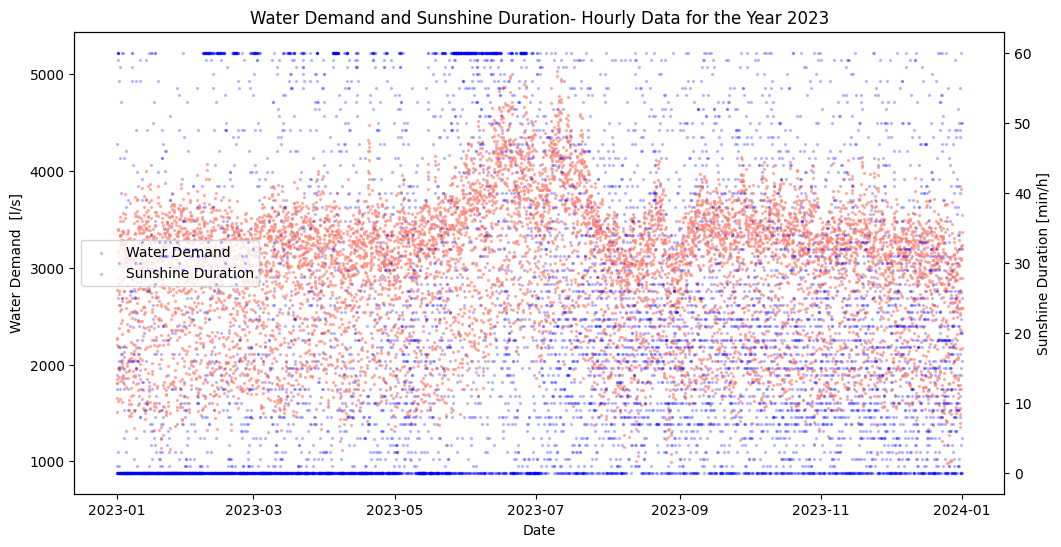

In [ ]:
# Plot - Water Demand and Sunshine Duration
fig, ax1 = plt.subplots(figsize=(12, 6))


# Create a label for the year

label = f"{start_date.year}"

scatter1 = ax1.scatter(
    year_data.index,

    year_data["nodal_demand"],

    s=2,  # Size of dots

    alpha=0.5,  # Transparency of dots

    label="Water Demand",

    color="salmon",
)

ax1.set_xlabel("Date")

ax1.set_ylabel("Water Demand  [l/s]")


# Create a second y-axis for the sunshine duration

ax2 = ax1.twinx()

scatter2 = ax2.scatter(
    year_data.index,

    year_data["sunshine_duration_Schnar"],

    s=2,  # Size of dots

    alpha=0.2,  # Transparency of dots

    label="Sunshine Duration",
    color="blue",
)

ax2.set_ylabel("Sunshine Duration [min/h]")

# Add grid

# plt.grid(visible=True, linestyle="--", alpha=0.5)


# Combine legends

scatters = [scatter1, scatter2]

labels = [scatter.get_label() for scatter in scatters]

ax1.legend(scatters, labels, loc=6)


plt.title(

    f"Water Demand and Sunshine Duration- Hourly Data for the Year {start_date.year}"
)

plt.show()

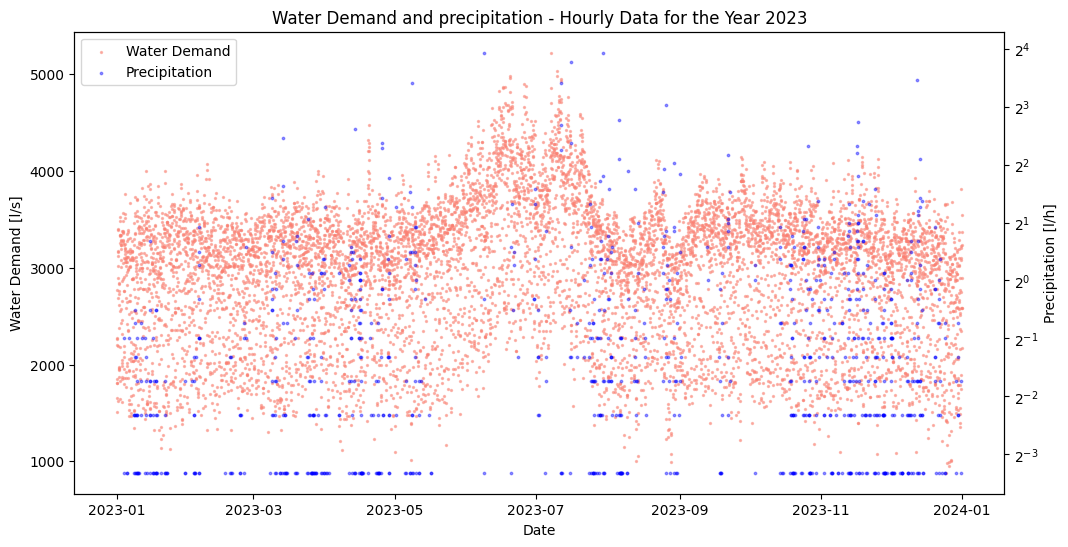

In [ ]:
# Plot - Water Demand and Precipitation
fig, ax1 = plt.subplots(figsize=(12, 6))


# Create a label for the year

label = f"{start_date.year}"

scatter1 = ax1.scatter(
    year_data.index,

    year_data["nodal_demand"],

    s=2,  # Size of dots

    alpha=0.5,  # Transparency of dots

    label="Water Demand",

    color="salmon",
)

ax1.set_xlabel("Date")

ax1.set_ylabel("Water Demand [l/s]")

# Create a second y-axis for the temperature

ax2 = ax1.twinx()

scatter2 = ax2.scatter(
    year_data.index,

    year_data["precipitation_Schnar"],

    s=3,  # Size of dots

    alpha=0.4,  # Transparency of dots

    label="Precipitation",

    color="blue",
)

ax2.set_ylabel("Precipitation [l/h]")

ax2.set_yscale("log", base=2)  # Set log scale for the precipitation


# Combine legends

scatters = [scatter1, scatter2]

labels = [scatter.get_label() for scatter in scatters]

ax1.legend(scatters, labels, loc="upper left")

plt.title(

    f"Water Demand and precipitation - Hourly Data for the Year {start_date.year}"
)

plt.show()

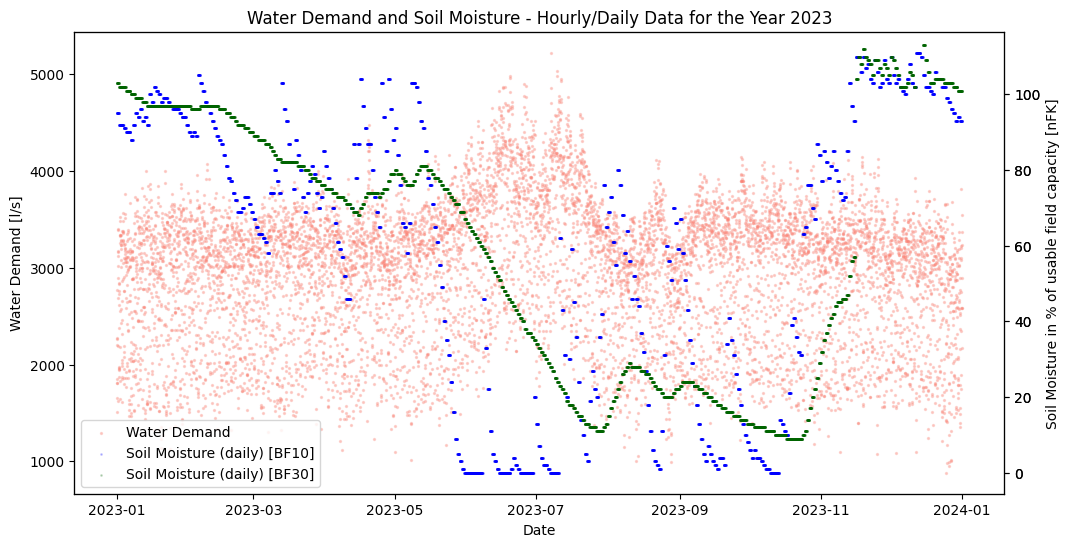

In [149]:
# Plot - Water Demand and Soil Moisture
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year


label = f"{start_date.year}"

scatter1 = ax1.scatter(
    year_data.index,

    year_data["nodal_demand"],

    s=2,  # Size of dots

    alpha=0.3,  # Transparency of dots

    label="Water Demand",

    color="salmon",
)


ax1.set_xlabel("Date")

ax1.set_ylabel("Water Demand [l/s]")


# Create a second y-axis for the temperature

ax2 = ax1.twinx()


scatter2 = ax2.scatter(
    year_data.index,

    year_data["BF10"],

    s=1,  # Size of dots

    alpha=0.2,  # Transparency of dots

    label="Soil Moisture (daily) [BF10]",

    color="blue",
)

ax2.set_ylabel("Soil Moisture in % of usable field capacity [nFK]")


ax3 = ax1.twinx()

scatter3 = ax3.scatter(
    year_data.index,

    year_data["BF30"],

    s=1,  # Size of dots

    alpha=0.2,  # Transparency of dots

    label="Soil Moisture (daily) [BF30]",

    color="darkgreen",
)

ax3.set_xlim(ax2.get_xlim())

ax3.set_ylim(ax2.get_ylim())


# Combine legends


scatters = [scatter1, scatter2, scatter3]

labels = [scatter.get_label() for scatter in scatters]

ax1.legend(scatters, labels, loc="lower left")

plt.title(

    f"Water Demand and Soil Moisture - Hourly/Daily Data for the Year {start_date.year}"
)


plt.show()

#### 2.2.) Short Term

In [153]:
start_date = "2023-06-26"
end_date = "2023-07-25"
short_term_df = df_merged[
    (df_merged.index >= start_date) & (df_merged.index < end_date)
]

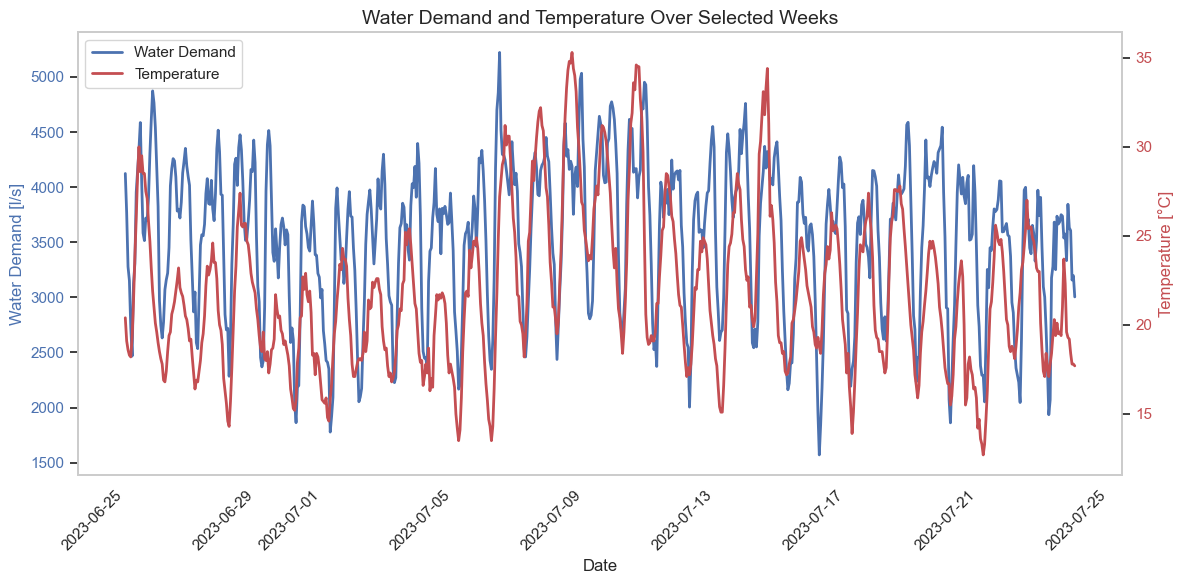

In [ ]:
# Plot - Water Demand for selected Weeks
sns.set(style="whitegrid")

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the nodal_demand
ax1.plot(
    short_term_df.index,
    short_term_df["nodal_demand"],
    label="Water Demand",
    color="b",
    linewidth=2,
)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Water Demand [l/s]", color="b", fontsize=12)
ax1.tick_params(axis="x", rotation=45)
ax1.tick_params(axis="y", labelcolor="b")

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(
    short_term_df.index,
    short_term_df["temperature_Schnar"],
    label="Temperature",
    color="r",
    linewidth=2,
)
ax2.set_ylabel("Temperature [°C]", color="r", fontsize=12)
ax2.tick_params(axis="y", labelcolor="r")

# Add grid
ax1.grid(visible=False)
ax2.grid(visible=False)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# Add title
plt.title("Water Demand and Temperature Over Selected Weeks", fontsize=14)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [154]:
# Extract the hour and date from the timestamp
year_data["hour"] = year_data.index.hour
year_data["date"] = year_data.index.date


# Separate the data into working days and weekends
working_days = year_data.loc[year_data["is_weekend"] == False].copy()
weekends = year_data.loc[year_data["is_weekend"] == True].copy()
holidays = year_data.loc[year_data["is_holiday"] == True].copy()

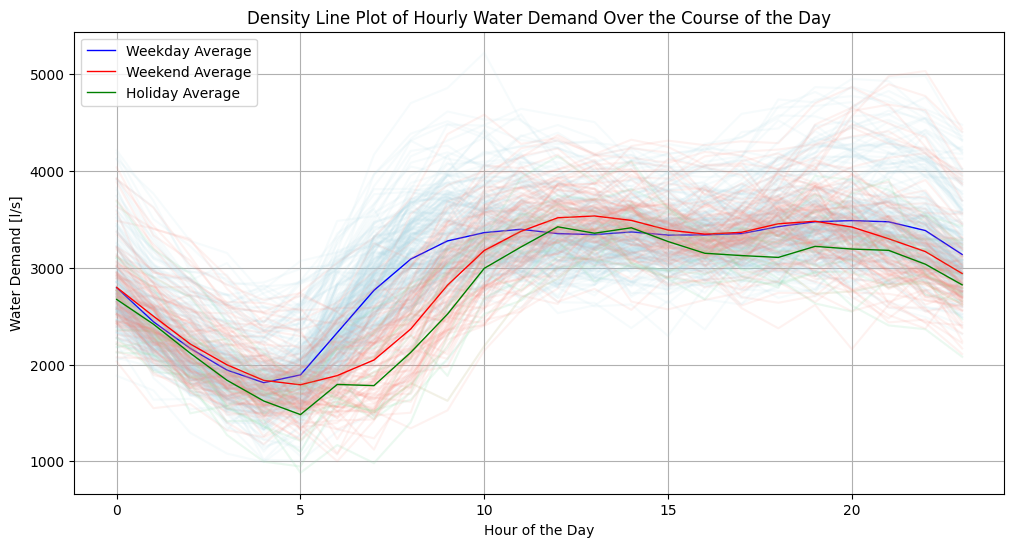

In [161]:
# Plot - Water Demand over the course of a Day
pivot_wd = (
    working_days.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)
pivot_we = (
    weekends.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)
pivot_ho = (
    holidays.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)

plt.figure(figsize=(12, 6))

# Plot each weekday's daily line in a faint color
for day in pivot_wd.index:
    plt.plot(pivot_wd.columns, pivot_wd.loc[day], color="lightblue", alpha=0.1)

# Plot the average weekday demand line in thicker blue
avg_wd = pivot_wd.mean(axis=0)
plt.plot(pivot_wd.columns, avg_wd, color="blue", linewidth=1, label="Weekday Average")

# Plot each weekend day's daily line in a faint color
for day in pivot_we.index:
    plt.plot(pivot_we.columns, pivot_we.loc[day], color="salmon", alpha=0.1)

# Plot the average weekend demand line in thicker red
avg_we = pivot_we.mean(axis=0)
plt.plot(pivot_we.columns, avg_we, color="red", linewidth=1, label="Weekend Average")

# Plot each holiday daily line in a faint color
for day in pivot_ho.index:
    plt.plot(pivot_ho.columns, pivot_ho.loc[day], color="lightgreen", alpha=0.1)

# Plot the average holiday demand line in thicker red
avg_ho = pivot_ho.mean(axis=0)
plt.plot(pivot_ho.columns, avg_ho, color="green", linewidth=1, label="Holiday Average")

# Final styling
plt.xlabel("Hour of the Day")
plt.ylabel("Water Demand [l/s]")
plt.title("Density Line Plot of Hourly Water Demand Over the Course of the Day")
plt.legend()
plt.grid(True)
plt.show()

### 3.) SARIMA Model - One Day Ahead Forecast

#### 3.1.) Identifying the dependence orders of the model

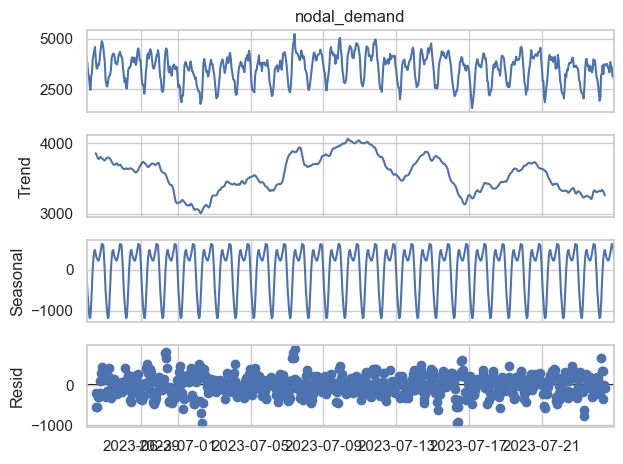

In [48]:
# Decompose the selected weeks water demand
decomposition = seasonal_decompose(

    short_term_df["nodal_demand"], model="additive", period=24

)

decomposition.plot()

plt.show()

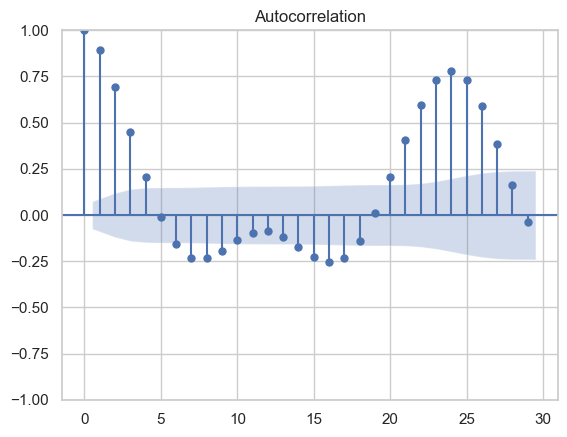

In [49]:
plot_acf(short_term_df["nodal_demand"])
plt.show()

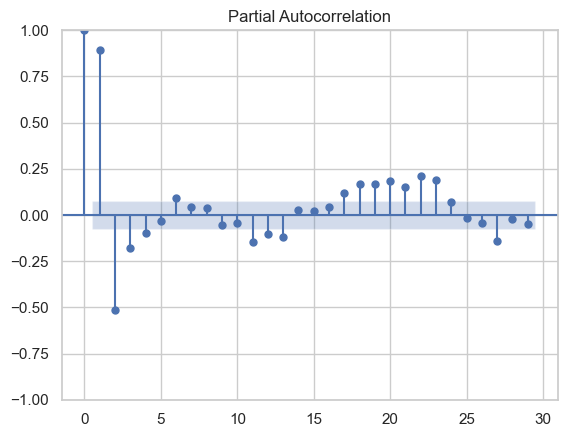

In [50]:
plot_pacf(short_term_df["nodal_demand"])
plt.show()

#### 3.2.) Fitting the Model

In [23]:
rolling_seven_day_forecast = []
for days in range(0, 7):
    train_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=days)
    train_end_date = train_start_date + pd.Timedelta(days=14) - pd.Timedelta(hours=1)
    fc = train_and_forecast_sarima(short_term_df, train_start_date, train_end_date, 24)
    rolling_seven_day_forecast.append(fc)

order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4672.94
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4681.32
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4680.98
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4684.1
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4675.28
order: (1, 0, 1) x (2, 0, 0, 24) ; BIC: 4661.07
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4656.31


In [24]:
forecast = np.array(rolling_seven_day_forecast).flatten()
test_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=14)
test_end_date = test_start_date + pd.Timedelta(days=7)
measured = filtered_df.loc[
    (filtered_df.index >= test_start_date) & (filtered_df.index < test_end_date),
    ["nodal_demand"],
]
error = measured["nodal_demand"] - forecast  # Calculate error

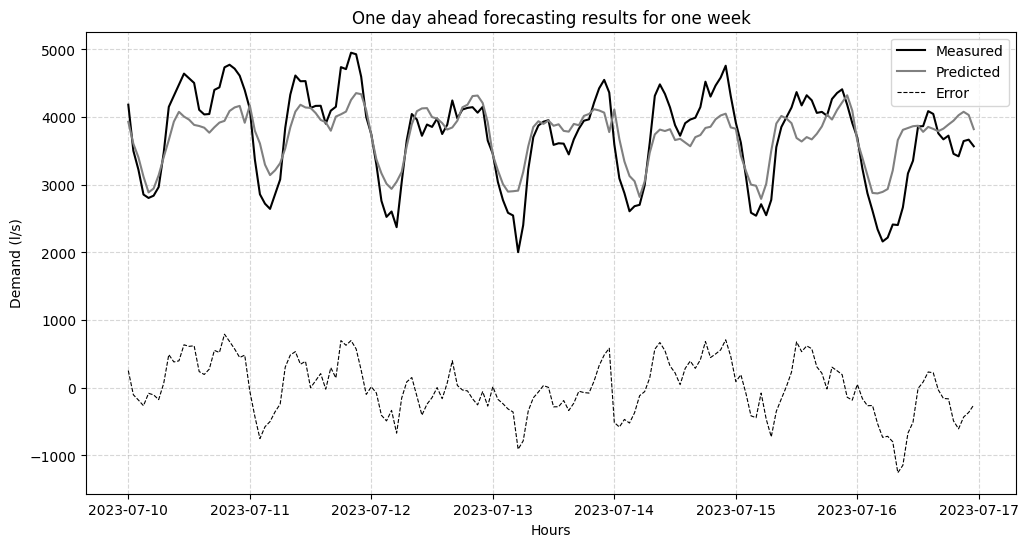

In [25]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot measured and predicted demand
plt.plot(measured.index, measured, label="Measured", color="black", linewidth=1.5)
plt.plot(measured.index, forecast, label="Predicted", color="gray", linewidth=1.5)

# Plot error
plt.plot(
    measured.index, error, label="Error", color="black", linestyle="--", linewidth=0.8
)

# Add labels, legend, and title
plt.xlabel("Date")
plt.ylabel("Water Demand [l/s]")
plt.title("One Day Ahead Forecasting Results for One Week - 07/2023")
plt.legend()

# Add grid
plt.grid(visible=True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

### 4.) SARIMAX - Weather Based
Mid-term forecast based on exogoneous variables and time-serie decomposition

In [79]:
# Select 3 year period
start_date = pd.Timestamp("2021-01-01T00")

end_date = pd.Timestamp("2023-12-31T23")

sarimax_df = df_merged.loc[start_date:end_date].copy()

In [80]:
#  Prepare the data
endog = sarimax_df["nodal_demand"]
exog = sarimax_df[
    [
        # "T_hot",
        "T_hot^2",
        "is_weekend",
        "is_holiday",
        # "temperature_Schnar",
        # "dry_soil",
        "dry_soil_10*temperature_Schnar",
        # "dry_soil_30*temperature_Schnar",
        "dry_soil_10*T_hot",
        # "dry_soil_30*T_hot",
        # "precipitation_Schnar",
        # "T_hot*sunshine_duration_Schnar",
        # "T_hot*precipitation_Schnar",
        # "sin_168_1",
        # "cos_168_1",
        # "sin_168_2",
        # "cos_168_2",
        # "sin_168_3",
        # "cos_168_3",
    ]
]

# Split the data into training and testing sets (optional)
train_endog = endog[: 2 * 365 * 24]
test_endog = endog[2 * 365 * 24 + 1 :]
train_exog = exog[: 2 * 365 * 24]
test_exog = exog[2 * 365 * 24 + 1 :]

#### 4.1.) Determine model parameters

In [81]:
# Fit the SARIMAX model
model = SARIMAX(
    train_endog, exog=train_exog, order=(1, 0, 3), seasonal_order=(0, 1, 1, 24)
)
results = model.fit()
# Print the summary of the model
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         nodal_demand   No. Observations:                17520
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 24)   Log Likelihood             -117366.756
Date:                              Tue, 04 Feb 2025   AIC                         234755.511
Time:                                      10:37:40   BIC                         234840.978
Sample:                                  01-01-2021   HQIC                        234783.656
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
T_hot                             39.6312     22.227      

In [82]:
# Make predictions one year ahead
predictions = results.get_forecast(steps=364 * 24 + 23, exog=test_exog)
predicted_mean = pd.DataFrame(predictions.predicted_mean).set_index(test_endog.index)

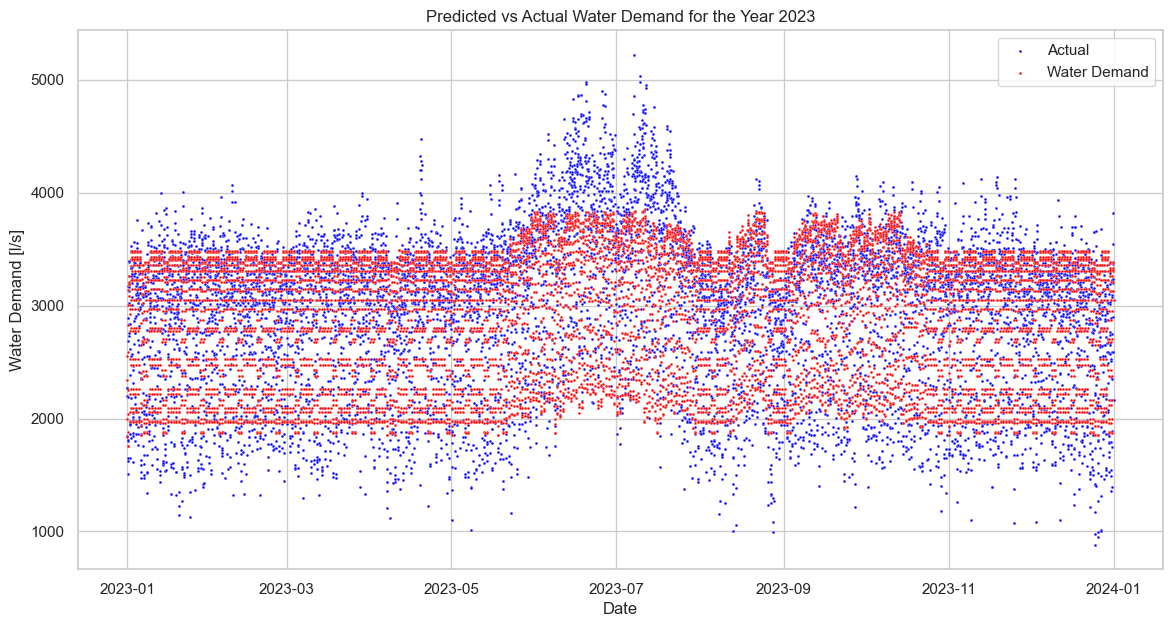

In [83]:
# Plot - SARIMAX Forecast against Actual for 2023
plt.figure(figsize=(14, 7))
sns.scatterplot(

    x="datetime",

    y="nodal_demand",

    data=pd.DataFrame(test_endog),

    label="Actual",

    color="blue",

    s=4,
)
sns.scatterplot(

    x="datetime",

    y="predicted_mean",

    data=pd.DataFrame(predicted_mean),

    label="Water Demand",
    color="red",

    s=4,
)

plt.xlabel("Date")

plt.ylabel("Water Demand [l/s]")

plt.title("Predicted vs Actual Water Demand for the Year 2023")

plt.legend()

plt.show()

In [84]:
#  Calculate MSE
mse = mean_squared_error(test_endog, predicted_mean["predicted_mean"])

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(test_endog, predicted_mean["predicted_mean"])

# Calculate MAPE
mape = (
    np.mean(np.abs((test_endog - predicted_mean["predicted_mean"]) / test_endog)) * 100
)

# Create a DataFrame to display the results
results = pd.DataFrame(
    {"Metric": ["MSE", "RMSE", "MAE", "MAPE"], "Value": [mse, rmse, mae, mape]}
)

print(results)

  Metric          Value
0    MSE  200972.686034
1   RMSE     448.299773
2    MAE     349.476497
3   MAPE      12.697579


### 5.) Prophet
Open Source forecasting package provided by Meta

In [ ]:
# Set the dataframe
prophet_df = df_merged[
    [
        "date",
        "nodal_demand",
        "T_hot",
        "T_hot^2",
        "is_weekend",
        "is_holiday",
        "dry_soil_10*temperature_Schnar",
        "dry_soil_30*temperature_Schnar",
        "dry_soil_10*T_hot",
        "dry_soil_30*T_hot",
    ]
].rename(columns={"date": "ds", "nodal_demand": "y"})



prophet_df.tail(5)

,ds,y,T_hot,T_hot^2,is_weekend,is_holiday,dry_soil_10*temperature_Schnar,dry_soil_30*temperature_Schnar,dry_soil_10*T_hot,dry_soil_30*T_hot
datetime,,,,,,,,,,
2023-12-31 19:00:00,2023-12-31 19:00:00,3234.205803,0.0,0.0,1,0,-0.0,-0.0,-0.0,-0.0
2023-12-31 20:00:00,2023-12-31 20:00:00,2897.477640,0.0,0.0,1,0,-0.0,-0.0,-0.0,-0.0
2023-12-31 21:00:00,2023-12-31 21:00:00,2588.741674,0.0,0.0,1,0,-0.0,-0.0,-0.0,-0.0
2023-12-31 22:00:00,2023-12-31 22:00:00,2588.316982,0.0,0.0,1,0,-0.0,-0.0,-0.0,-0.0
2023-12-31 23:00:00,2023-12-31 23:00:00,2166.669274,0.0,0.0,1,0,-0.0,-0.0,-0.0,-0.0


In [119]:
# Initialize Prophet model
m = Prophet(
    changepoint_prior_scale=0.25,  # indicates the flexiblity to account for trend changes, something between 0.01 and 0.5
    weekly_seasonality=True,
    yearly_seasonality=False,
    daily_seasonality=True,
)
# m.add_regressor("T_hot")
m.add_regressor("T_hot^2")
m.add_regressor("is_holiday")
m.add_regressor("dry_soil_10*temperature_Schnar")
m.add_regressor("dry_soil_10*T_hot")
m.add_regressor("dry_soil_30*T_hot")
# m.add_regressor("dry_soil_30*temperature_Schnar")

m.fit(prophet_df[: -365 * 24])

11:08:39 - cmdstanpy - INFO - Chain [1] start processing
11:09:35 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Compute Forecast and Check Regressors
forecast = m.predict(
    prophet_df[
        [
            "ds",
            "T_hot^2",
            "is_weekend",
            "is_holiday",
            "dry_soil_10*temperature_Schnar",
            "dry_soil_10*T_hot",
            "dry_soil_30*T_hot",
        ]
    ]
)
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,T_hot^2,additive,0.758065,3.787761,3.787761,3.787761
1,is_holiday,additive,0.000000,-252.526843,-252.526843,-252.526843
2,dry_soil_10*temperature_Schnar,additive,275.808733,0.440057,0.440057,0.440057
3,dry_soil_10*T_hot,additive,6.442360,-0.568286,-0.568286,-0.568286
4,dry_soil_30*T_hot,additive,3.763874,0.159023,0.159023,0.159023


#### 5.1.) Evaluation

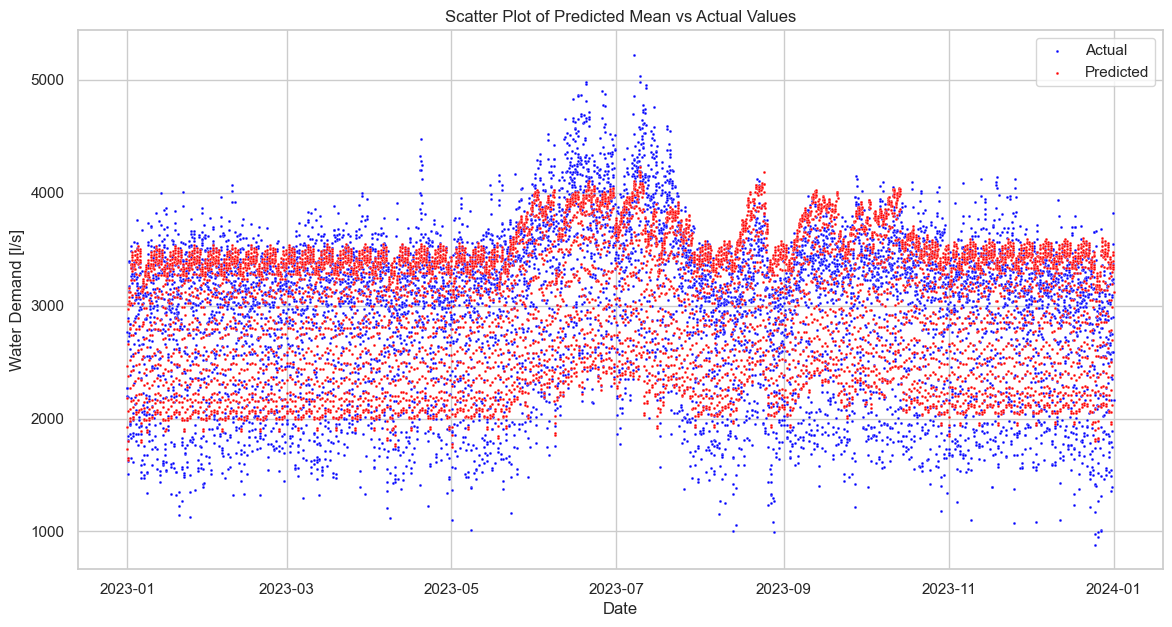

In [124]:
# Visually evaluate forecast for the test year 2023
prophet_df["y_hat"] = forecast["yhat"].values  # create forecast column
plt.figure(figsize=(14, 7))

sns.scatterplot(
    x="ds",
    y="y",
    data=prophet_df[-365 * 24 :],
    label="Actual",
    color="blue",
    s=4,
)
sns.scatterplot(
    x="ds",
    y="y_hat",
    data=prophet_df[-365 * 24 :],
    label="Predicted",
    color="red",
    s=4,
)
plt.xlabel("Date")
plt.ylabel("Water Demand [l/s]")
plt.title("Scatter Plot of Predicted Mean vs Actual Values")
plt.legend()
plt.show()

In [125]:
# Slice 2023 forecast
forecast_2023 = forecast[forecast["ds"].dt.year == 2023]

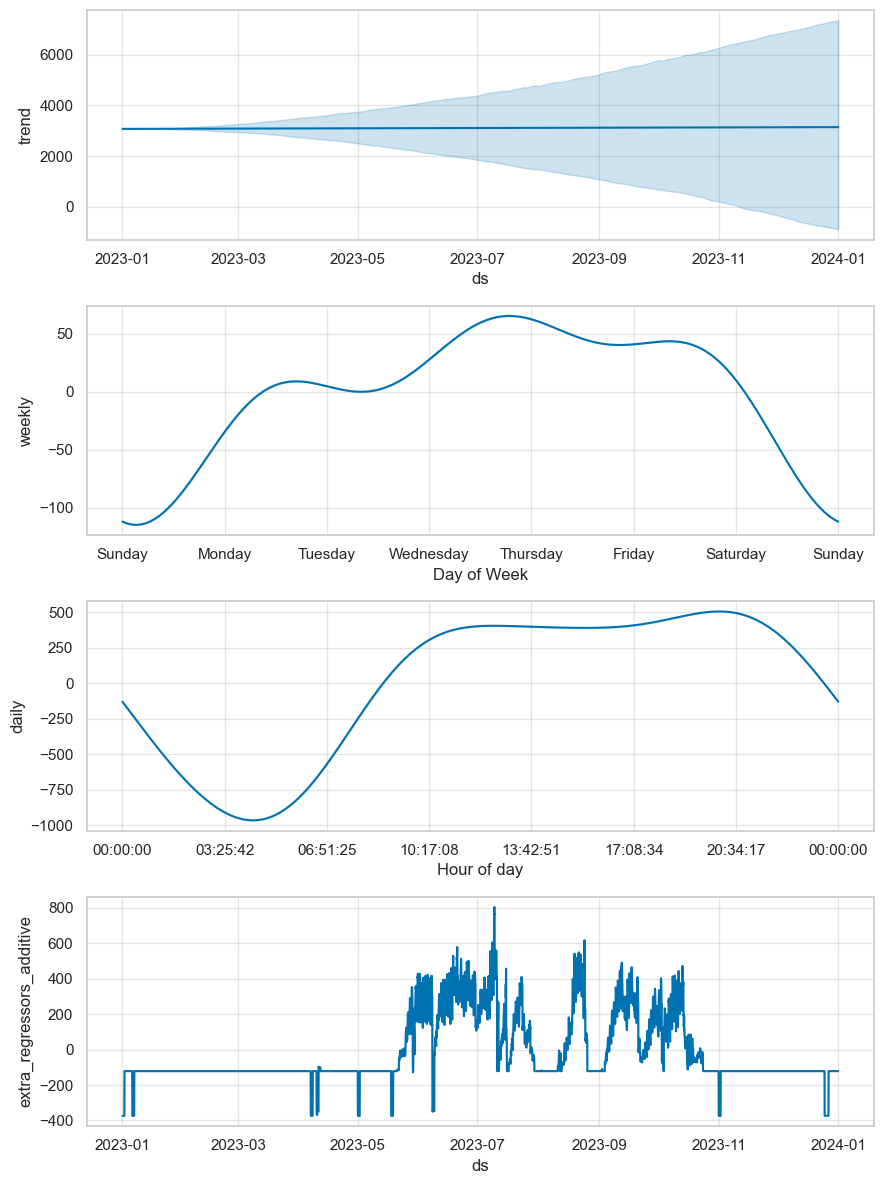

In [ ]:
# Decompose 2023 forecast
fig = m.plot_components(forecast_2023)

In [127]:
# Select 6 weeks of data to check for i week fit
week_indexes = [1, 12, 25, 30, 40, 50]
weeks = [prophet_df[-365 * 24 :].iloc[i * 168 : (i + 1) * 168] for i in week_indexes]

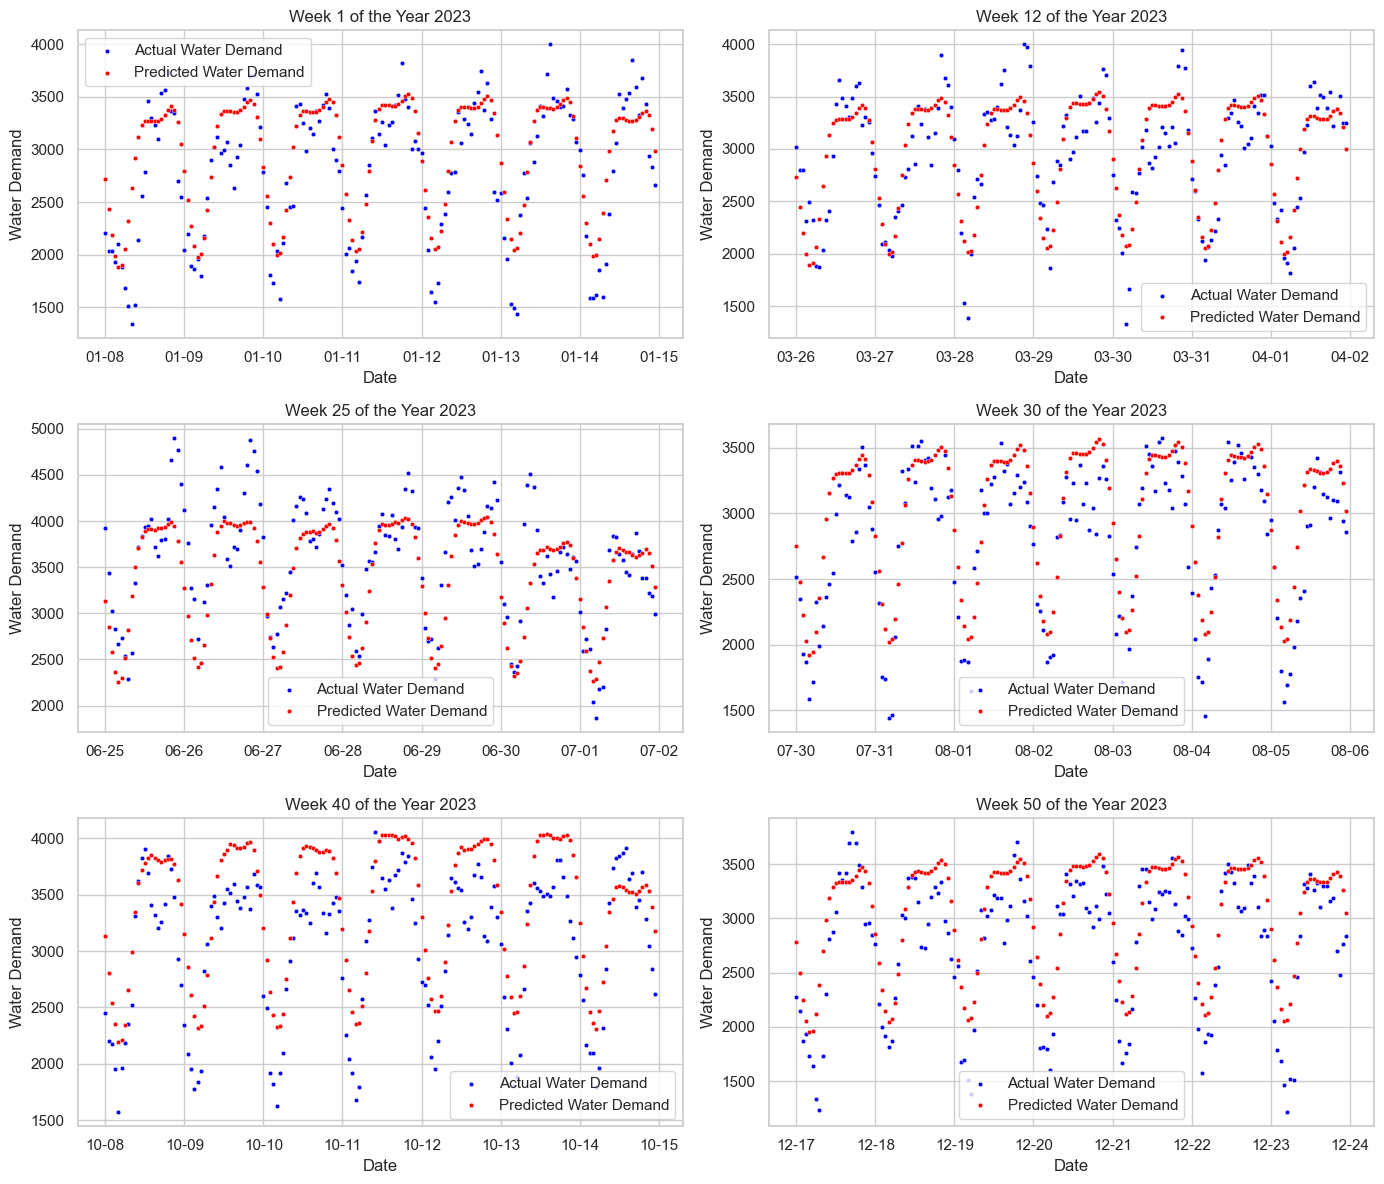

In [128]:
# Create the inweek plots for 6 selected weeks
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, week in enumerate(weeks):
    ax = axes[i // 2, i % 2]
    sns.scatterplot(
        x=week.index,
        y=week["y"],
        label="Actual Water Demand",
        color="blue",
        s=10,  # Size of dots
        ax=ax,
    )
    sns.scatterplot(
        x=week.index,
        y=week["y_hat"],
        label="Predicted Water Demand",
        color="red",
        s=10,  # Size of dots
        ax=ax,
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Water Demand")
    ax.set_title(f"Week {week_indexes[i]} of the Year 2023")
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))  # Format x-axis ticks

plt.tight_layout()
plt.show()

In [156]:
# Cross validate the model
df_cv = cross_validation(m, initial="1095 days", period="180 days", horizon="365 days")

  0%|          | 0/3 [00:00<?, ?it/s]

11:32:55 - cmdstanpy - INFO - Chain [1] start processing
11:33:16 - cmdstanpy - INFO - Chain [1] done processing
11:33:21 - cmdstanpy - INFO - Chain [1] start processing
11:33:51 - cmdstanpy - INFO - Chain [1] done processing
11:33:56 - cmdstanpy - INFO - Chain [1] start processing
11:34:34 - cmdstanpy - INFO - Chain [1] done processing


In [158]:
# Check perfomance metrics for selected forecasting horizons
df_p = performance_metrics(df_cv)  # create perfomance metric df

indices = [
    math.floor(i * len(df_p) / 10) for i in range(10)
]  # compute indices for 10 forecasting horizons



# Slice the DataFrame

df_p.iloc[indices]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,157939.043549,397.415455,303.630855,0.102279,0.077986,0.102833,0.742770
788,69 days 08:00:00,99666.839968,315.700554,247.695048,0.094690,0.068628,0.089866,0.866438
1577,102 days 05:00:00,82469.712173,287.175403,223.018133,0.077958,0.059940,0.076768,0.961568
2365,135 days 01:00:00,102509.711391,320.171378,254.022686,0.085271,0.070901,0.085783,0.998858
3154,167 days 22:00:00,119568.226003,345.786388,273.827393,0.091657,0.072377,0.090575,1.000000
3942,200 days 18:00:00,114793.352685,338.811677,265.764465,0.090462,0.072029,0.090075,1.000000
4731,233 days 15:00:00,119173.636828,345.215348,273.591423,0.092444,0.074456,0.091181,1.000000
5519,266 days 11:00:00,100013.501004,316.249112,248.713256,0.088637,0.069711,0.086425,1.000000
6308,299 days 08:00:00,112233.864689,335.013231,264.631263,0.089064,0.076367,0.091321,1.000000
7096,332 days 04:00:00,126299.919524,355.387000,282.835460,0.092264,0.081511,0.095644,1.000000


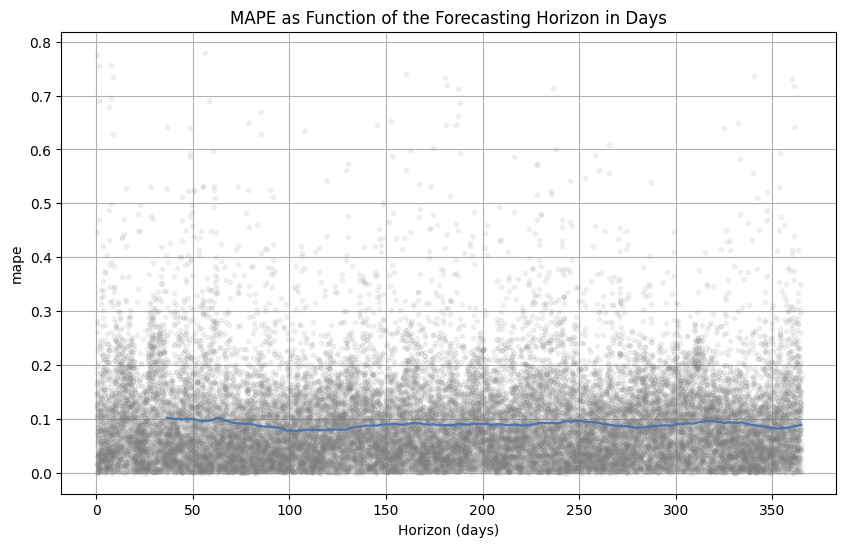

In [157]:
# Plot MAPE as function of forecasting horizon
fig = plot_cross_validation_metric(df_cv, metric="mape")
plt.title("MAPE as Function of the Forecasting Horizon in Days")
plt.show()